# 0.0 Importações

In [137]:
import math
import inflection

import pandas  as pd
import numpy   as np
import seaborn as sns
import datetime

from matplotlib            import pyplot as plt
from matplotlib            import gridspec
from scipy                 import stats as ss
from IPython.display       import Image
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from category_encoders     import OneHotEncoder, OrdinalEncoder

## 0.1 Funções Auxiliares

In [2]:
plt.rcParams['figure.figsize'] = [20, 10]

def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k-(k-1)**2/(n-1)
    rcorr = r-(r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

## 0.2 Carregando os Dados

In [3]:
# Carrega os dados de Treino
df_train = pd.read_csv('dados/train.csv', low_memory=False)

# Carrega os dados das lojas
df_store = pd.read_csv('dados/store.csv', low_memory=False)

# Junta os dados de Treino e Loja
df_raw = pd.merge(df_train, df_store, how='left', on='Store')

In [4]:
# Mostra uma linha do dataset
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
184730,756,1,2015-02-16,6509,828,1,1,0,0,a,c,50.0,NaN,NaN,1,40.0,2011.0,"Jan,Apr,Jul,Oct"


# 1.0 Descrição dos Dados

In [5]:
# Faz uma copia do dataset
df1 = df_raw.copy()

## 1.1 Renomeando as Colunas

In [6]:
# Antigos nomes das colunas
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

# Cria a função que faz o nome das colunas virarem snake case (separados por _)
snakecase = lambda x: inflection.underscore(x)

# Aplica a função em todas os nomes de colunas e os coloca em uma variável
cols_new = list(map(snakecase, cols_old))

# Renomeia as colunas
df1.columns = cols_new

## 1.2 Dimensão dos Dados

In [7]:
print('Número de linhas: {}'.format(df1.shape[0]))
print('Número de colunas: {}'.format(df1.shape[1]))

Número de linhas: 1017209
Número de colunas: 18


## 1.3 Tipos dos Dados

In [8]:
# Transforma a coluna "date" de object para datetime
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Verifica NA

In [9]:
# Verifica se existem dados faltantes nas colunas
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Preenchendo NA

In [10]:
#competition_distance 
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] =  df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year 
df1['competition_open_since_year'] =  df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)                

#promo2_since_week
df1['promo2_since_week'] =  df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)                

#promo2_since_year         
df1['promo2_since_year'] =  df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)                

#promo_interval
month_map = {1: 'Jan',2: 'Fev',3: 'Mar',4: 'Apr',5: 'May',6: 'Jun',7: 'Jul',8: 'Aug',9: 'Sep',10: 'Oct',11: 'Nov',12: 'Dec'}
df1['promo_interval'].fillna(0,inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [11]:
# Verifica se resolvemos todos os dados não preenchidos
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Alterando Tipos de Dados

In [12]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## 1.7 Estatística descritiva

In [13]:
# Atributos numéricos
num_attributes = df1.select_dtypes(include=['int64','float64'])

# Atributos categóricos
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 1.7.1 Atributos Numéricos

In [14]:
# Tendencia central - mean, median
tc1 = pd.DataFrame(num_attributes.apply(np.mean)).T
tc2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Disperção - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenando
m = pd.concat([d2,d3,d4,tc1,tc2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2 Atributos Categóricos

In [15]:
# Níveis das variáveis categóricas
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

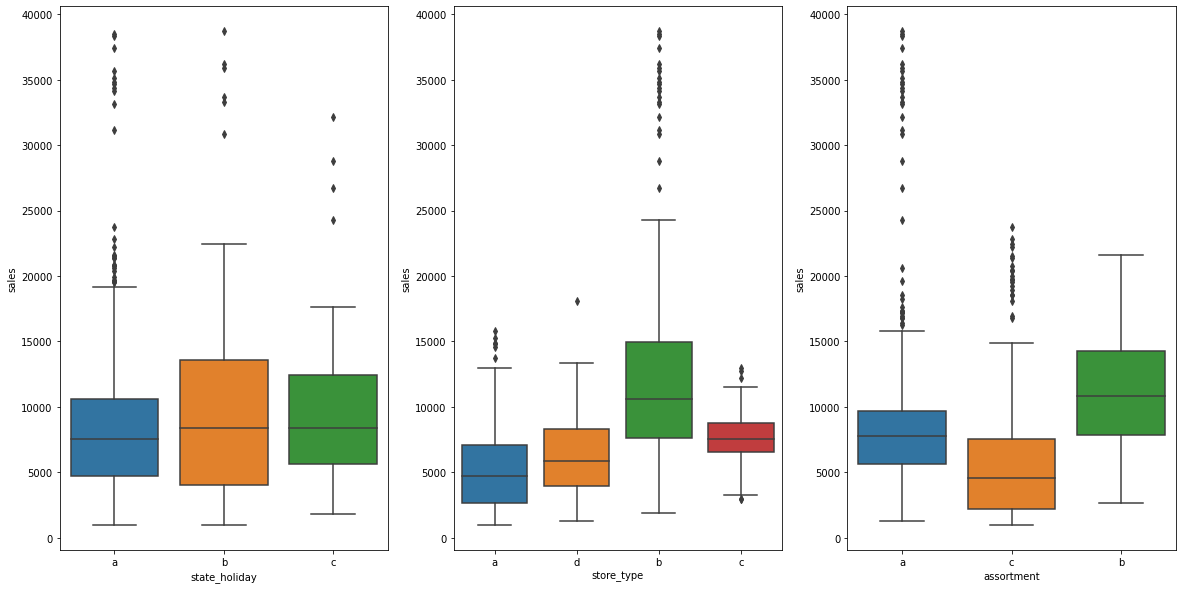

In [16]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
sns.boxplot(data=aux1, x='state_holiday', y='sales')

plt.subplot(1,3,2)
sns.boxplot(data=aux1, x='store_type', y='sales')

plt.subplot(1,3,3)
sns.boxplot(data=aux1, x='assortment', y='sales');

# 2.0 Criação de Novos Atributos
Feature Engineering

In [17]:
# Faz uma copia do dataset
df2 = df1.copy()

In [18]:
# Criação dos novos atributos

# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype('int64')

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype('int64')

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# 3.0 Filtragem de Variáveis

In [19]:
# Faz uma copia do dataset
df3 = df2.copy()

## 3.1 Filtragem das Linhas

In [20]:
# open  - Não podemos fazer previsões de vendas da loja se a loja estiver fechada, então vamos trabalhar apenas com as lojas abertas.
# sales - Quando a loja está fechada tenho venda 0. Vamos trabalhar apenas com lojas que tiveram vendas.
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Seleção da Colunas

In [21]:
# customers      - esse dado não vai estar disponível na hora de fazer a previsão.
# open           - como vamos trabalhar apenas com as lojas abertas, não precisamos mais desta coluna.
# promo_interval - utilizamos esta coluna para derivar a coluna is_promo 
# month_map      - coluna criada para auxiliar na criação da coluna is_promo 

cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0 Análise Exploratória de Dados

In [22]:
df4 = df3.copy()

## 4.1 Mapa Mental de Hipóteses

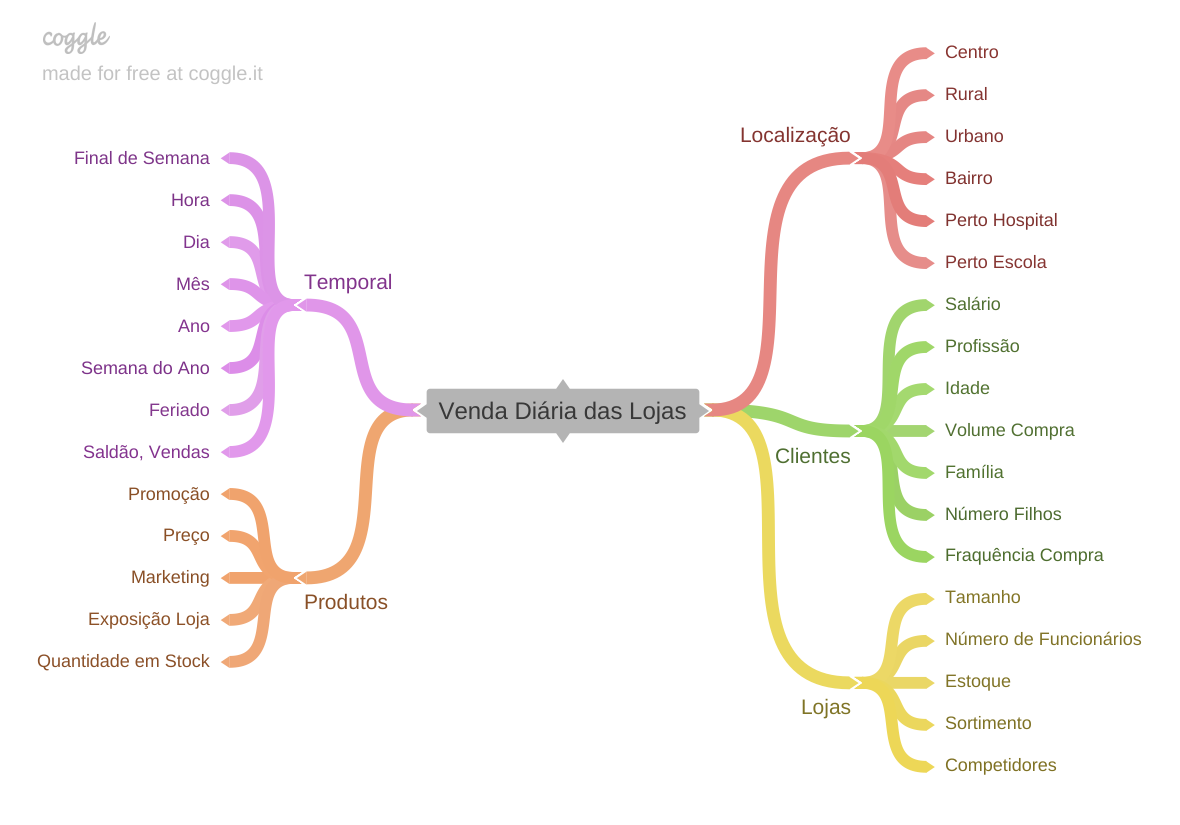

In [23]:
Image('img/Mapa_Mental_de_Hipóteses.png')

## 4.2 Criação das Hipóteses

### 4.2.1 Hipóteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores a mais tempo deveriam vender mais.

### 4.2.2 Hipóteses Produto

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas com maior exposição de produtos deveriam vender mais.

**3.** Lojas com produtos com preços menores deveriam vender mais.

**4.** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoções deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 4.2.3 Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

### 4.2.4 Lista Final de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais promoções consecutivas deveriam vender mais.

**6.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**7.** Lojas deveriam vender mais ao longo dos anos.

**8.** Lojas deveriam vender mais no segundo semestre do ano.

**9.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**10.** Lojas deveriam vender menos aos finais de semana.

**11.** Lojas deveriam vender menos durante os feriados escolares.

## 4.3 Análise Univariada

### 4.3.1 Variável Resposta

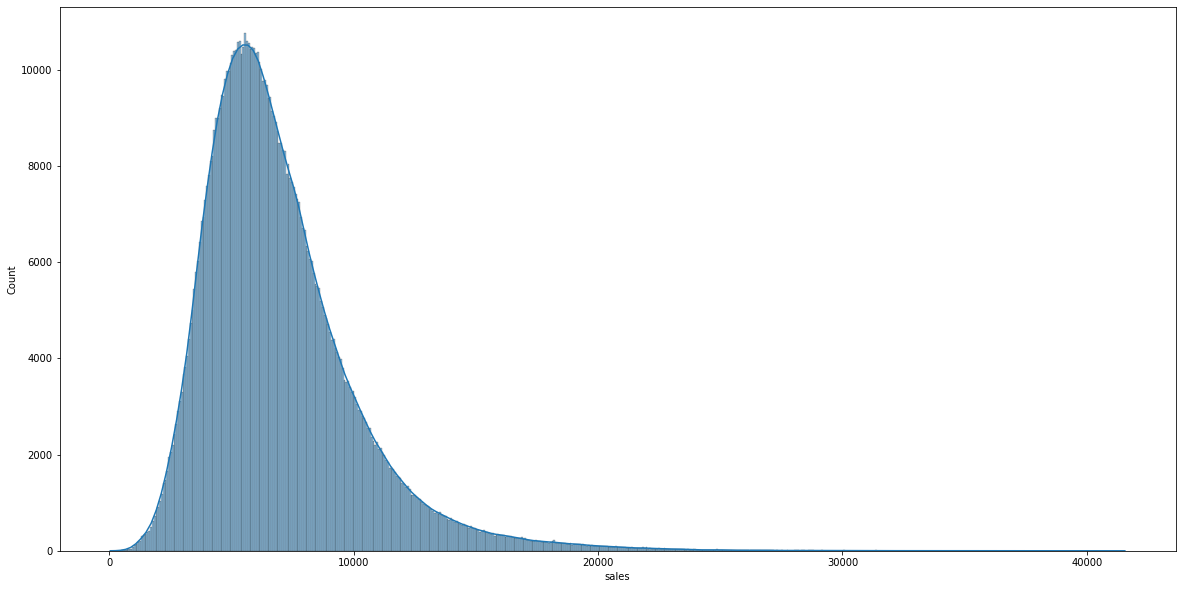

In [24]:
sns.histplot(df4['sales'], kde=True);

### 4.3.2 Variáveis Numéricas

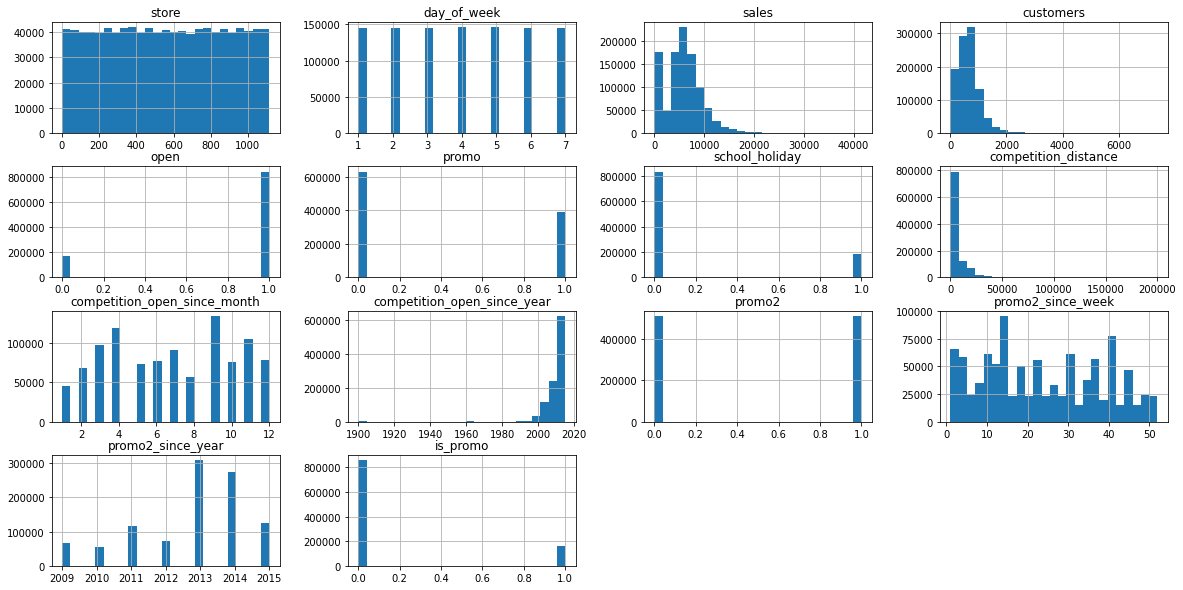

In [25]:
num_attributes.hist(bins=25);

### 4.3.3 Variáveis Categóricas

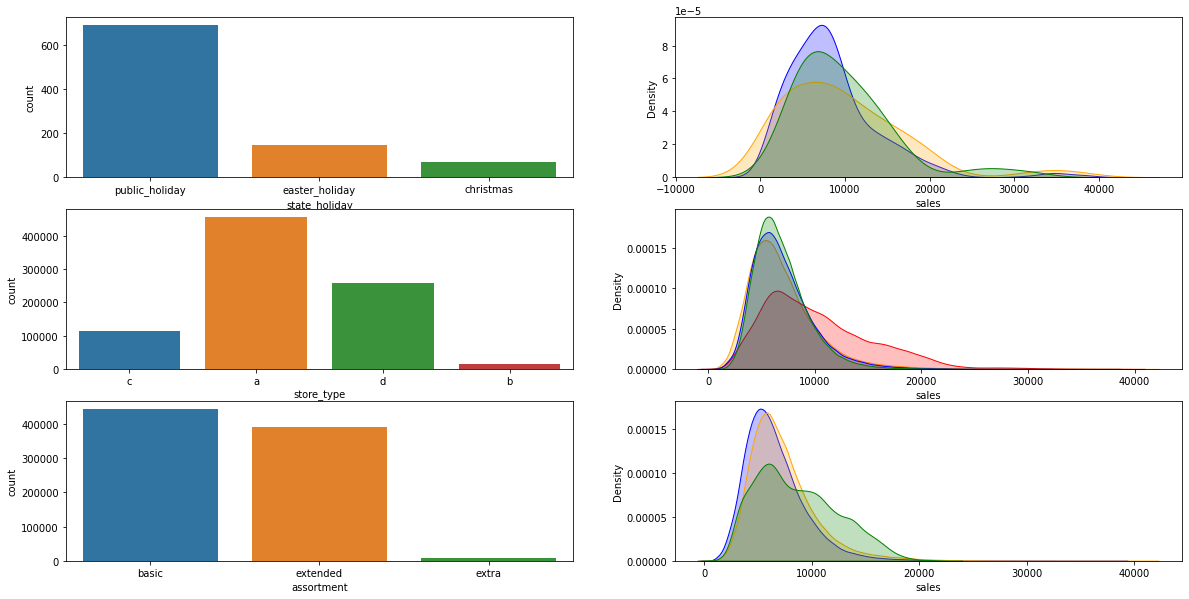

In [26]:
# state_holiday

plt.subplot(3,2,1)
aux = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(data=aux, x='state_holiday')

plt.subplot(3,2,2)
sns.kdeplot(aux[aux['state_holiday'] == 'public_holiday']['sales'], shade=True, color='blue')
sns.kdeplot(aux[aux['state_holiday'] == 'easter_holiday']['sales'], shade=True, color='orange')
sns.kdeplot(aux[aux['state_holiday'] == 'christmas']['sales'], shade=True, color='green')

# store_type
plt.subplot(3,2,3)
sns.countplot(data=df4, x='store_type')

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], shade=True, color='orange')
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], shade=True, color='red')
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], shade=True, color='blue')
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], shade=True, color='green')

# assortment
plt.subplot(3,2,5)
sns.countplot(data=df4, x='assortment')

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], shade=True, color='blue')
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], shade=True, color='orange')
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], shade=True, color='green');

**state_holiday**: Como podemos ver public_holiday tem um número muito maior de vendas, mas suas vendas estão mais concentradas em valores menores que os valores de easter_holiday e christmas.

**store_type**: A loja do tipo b tem um número bem pequeno de vendas, mas suas vendas tem um valor maior que do outros tipos de loja.

**assortment**: Os sortimentos basic e extended tem uma quantidade parecida de vendas e de valores. Se comparados ao sortimento extra, os dois primeiros tem um número muito maior de vendas mas a concentração de valores por venda é menor.

## 4.4 Análise Bivariada

### **H1.** Lojas com maior sortimento deveriam vender mais.

**VERDADEIRA** - Lojas com sortimento extra vendem mais.

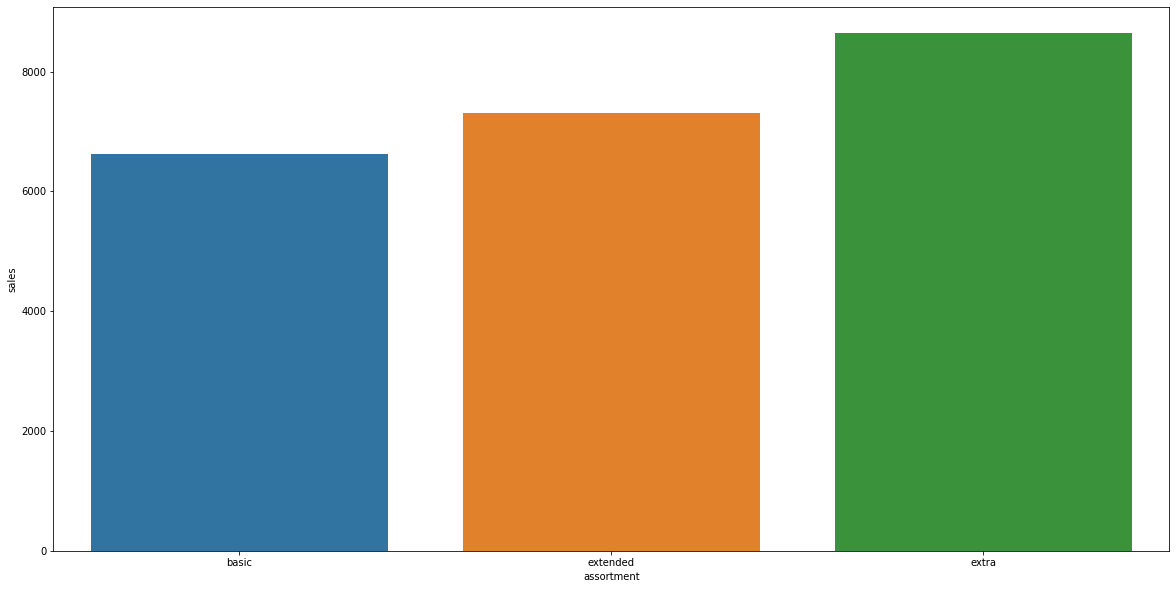

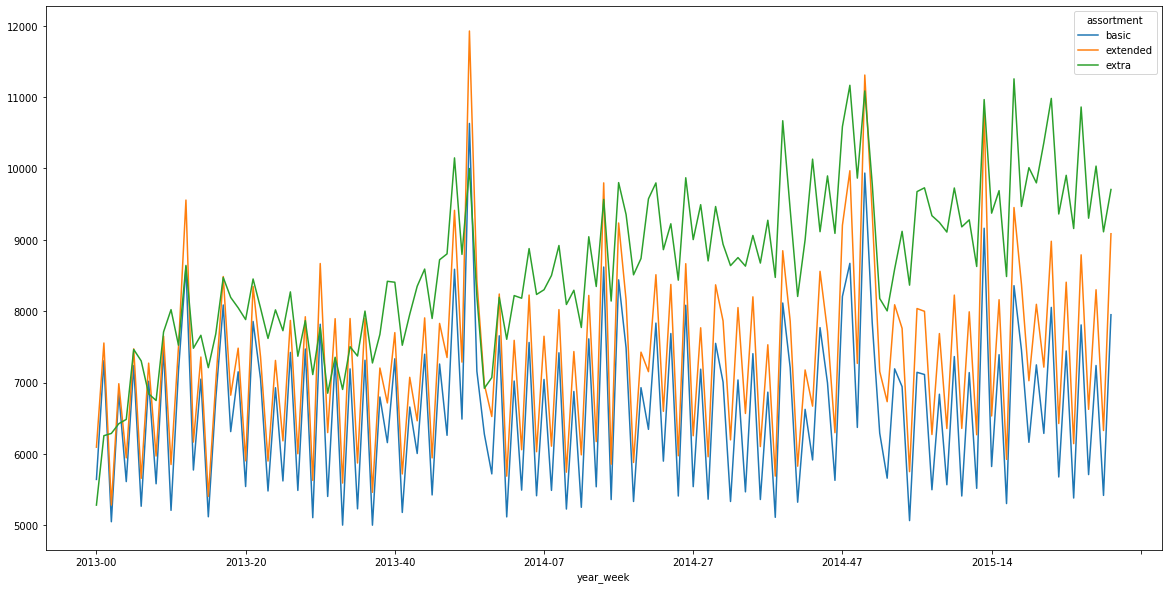

In [27]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').mean().reset_index()
sns.barplot(data=aux1, x='assortment', y='sales')

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).mean().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot();

### **H2.** Lojas com competidores mais próximos deveriam vender menos.

**FALSA** - Lojas com competidores mais próximos vendem mais.

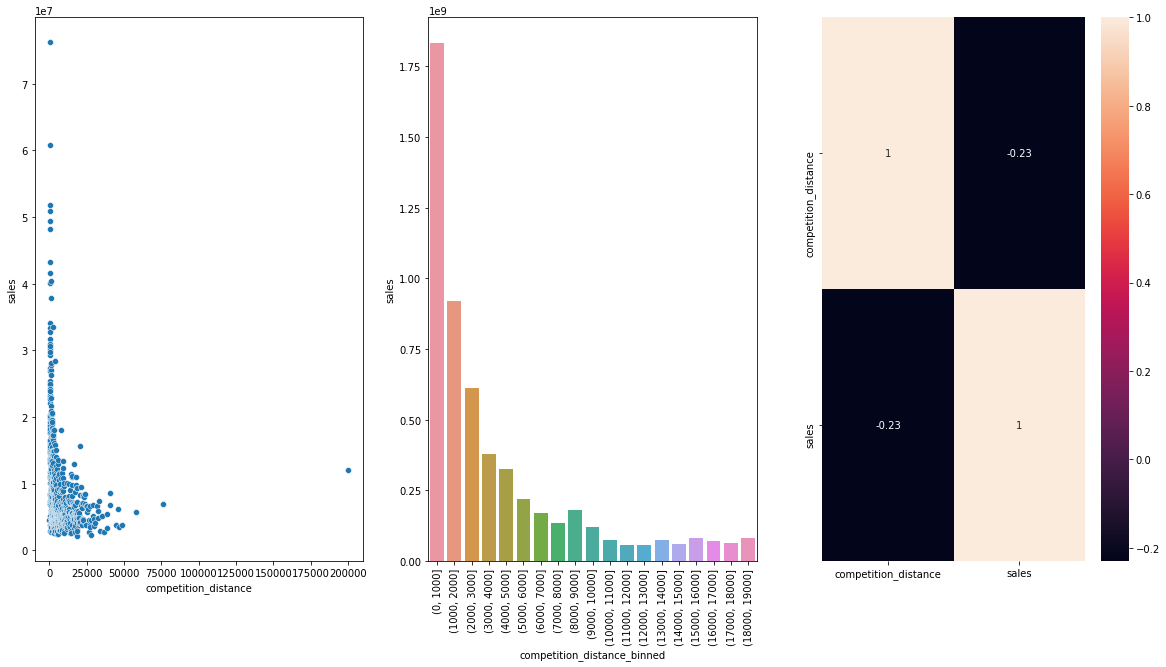

In [28]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,3,1)
sns.scatterplot(data=aux1, x='competition_distance', y='sales');

plt.subplot(1,3,2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(data=aux2, x='competition_distance_binned', y='sales');
plt.xticks(rotation=90);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H3.** Lojas com competidores a mais tempo deveriam vender mais.
**FALSA** - Lojas com competidores a mais tempo vendem menos.

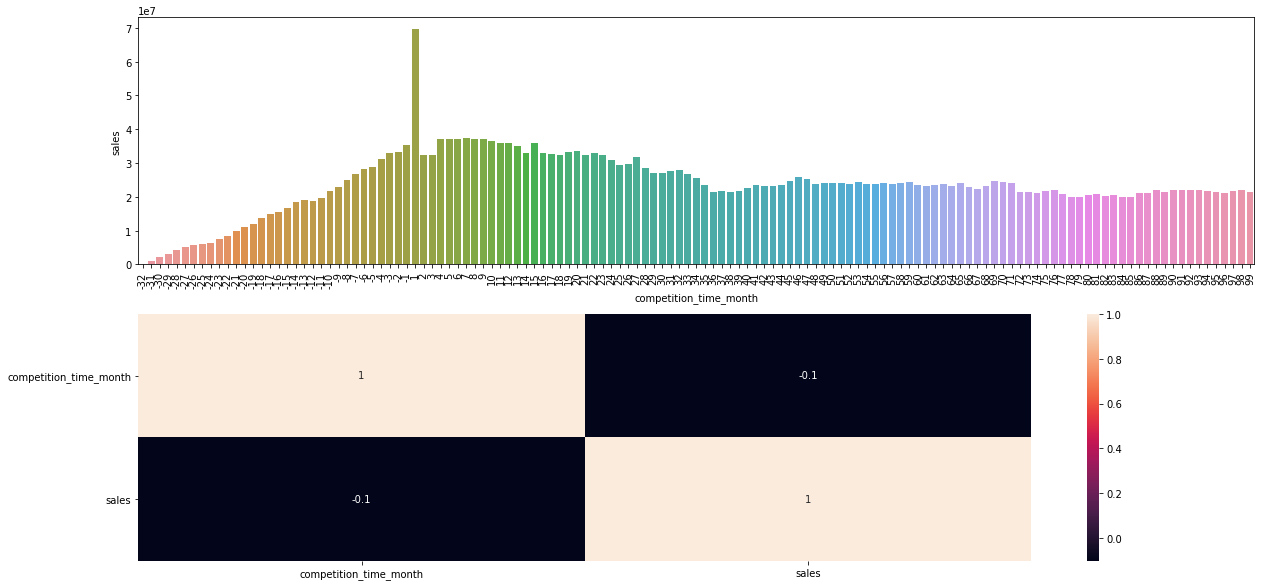

In [29]:
plt.subplot(2,1,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 100) & (aux1['competition_time_month'] != 0)]
sns.barplot(data=aux2, x='competition_time_month', y='sales');
plt.xticks(rotation=90);

plt.subplot(2,1,2)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** - Lojas com promoções ativas por mais tempo vendem menos depois de um certo período de promoção.

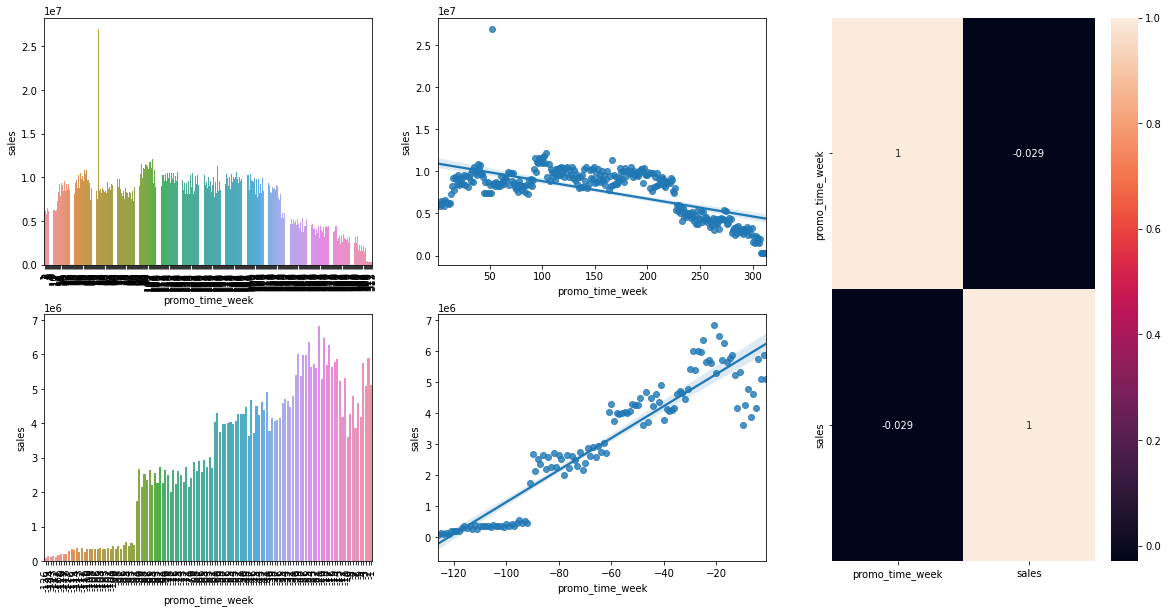

In [30]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

grid = gridspec.GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] # promoção extendida
sns.barplot(data=aux2, x='promo_time_week', y='sales');
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(data=aux2, x='promo_time_week', y='sales');

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] # promoção regular
sns.barplot(data=aux3, x='promo_time_week', y='sales');
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(data=aux3, x='promo_time_week', y='sales');

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H5.** Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** - Lojas com mais promoções consecutivas vendem menos.

In [31]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index().sort_values(by='sales')

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


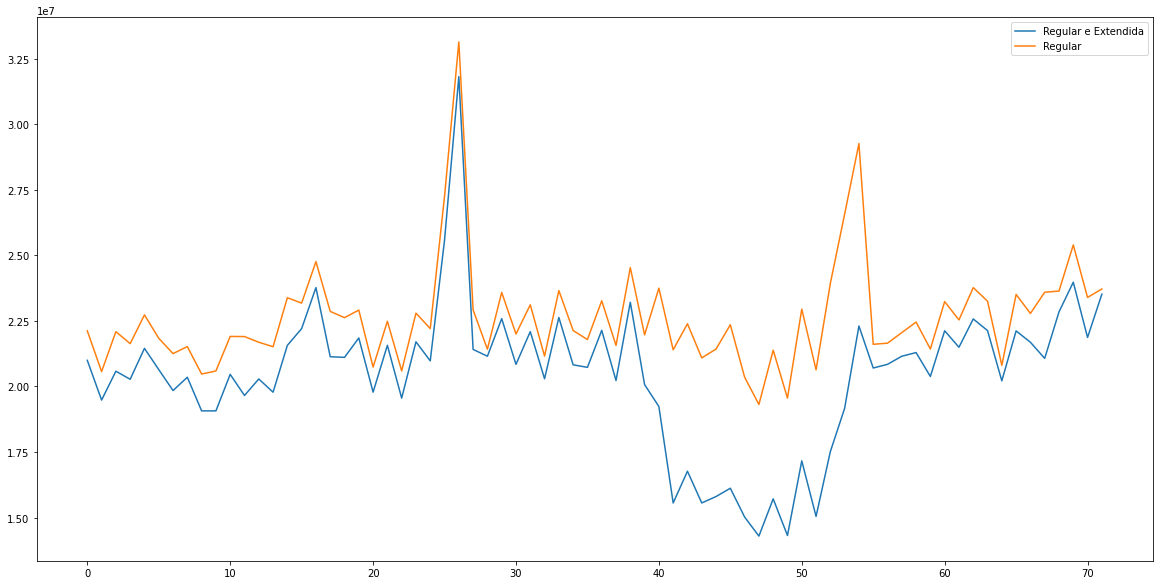

In [32]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot();

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax);

ax.legend(labels=['Regular e Extendida', 'Regular'])

### **H6.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** - Lojas abertas durante o feriado de natal vedem menos.

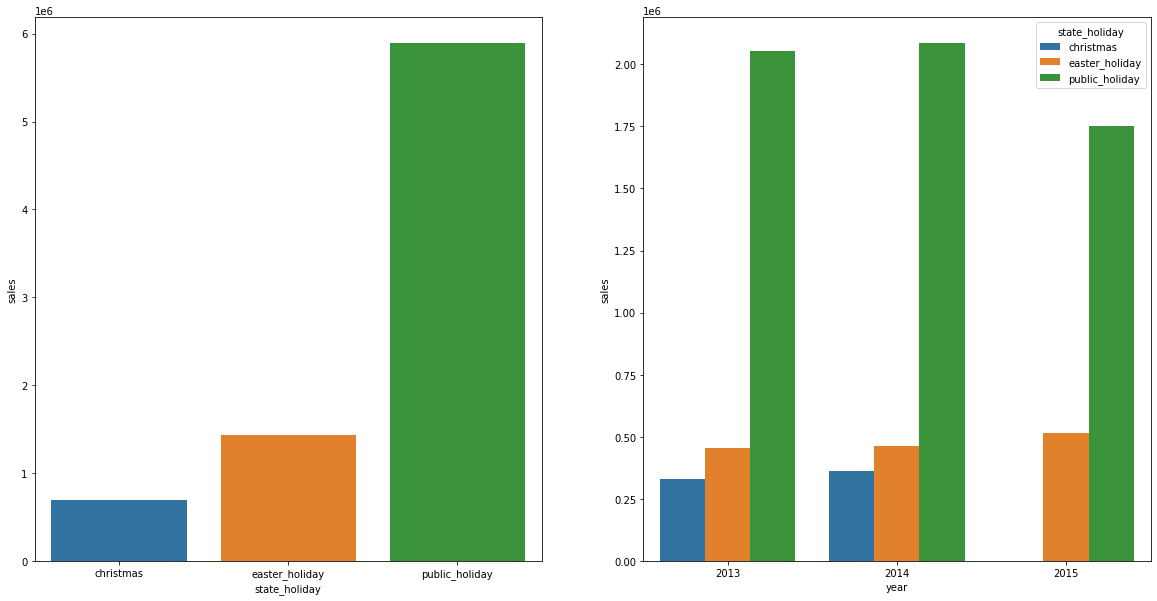

In [33]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(data=aux1, x='state_holiday', y='sales');

plt.subplot(1,2,2)
aux2 = aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(data=aux2, x='year', y='sales', hue='state_holiday');

### **H7.** Lojas deveriam vender mais ao longo dos anos.
**FALSA** - Lojas vendem menos ao longo dos anos.

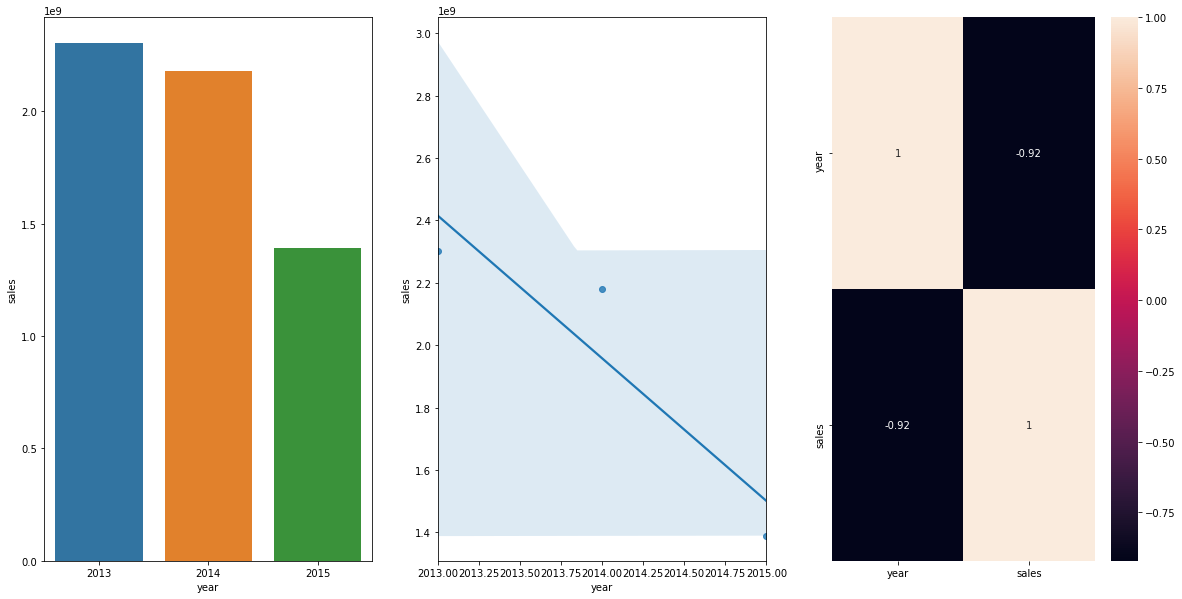

In [34]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(data=aux1, x='year', y='sales');

plt.subplot(1,3,2)
sns.regplot(data=aux1, x='year', y='sales');

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H8.** Lojas deveriam vender mais no segundo semestre do ano.
**FALSA** - Lojas vendem menos no segundo semestre do ano.

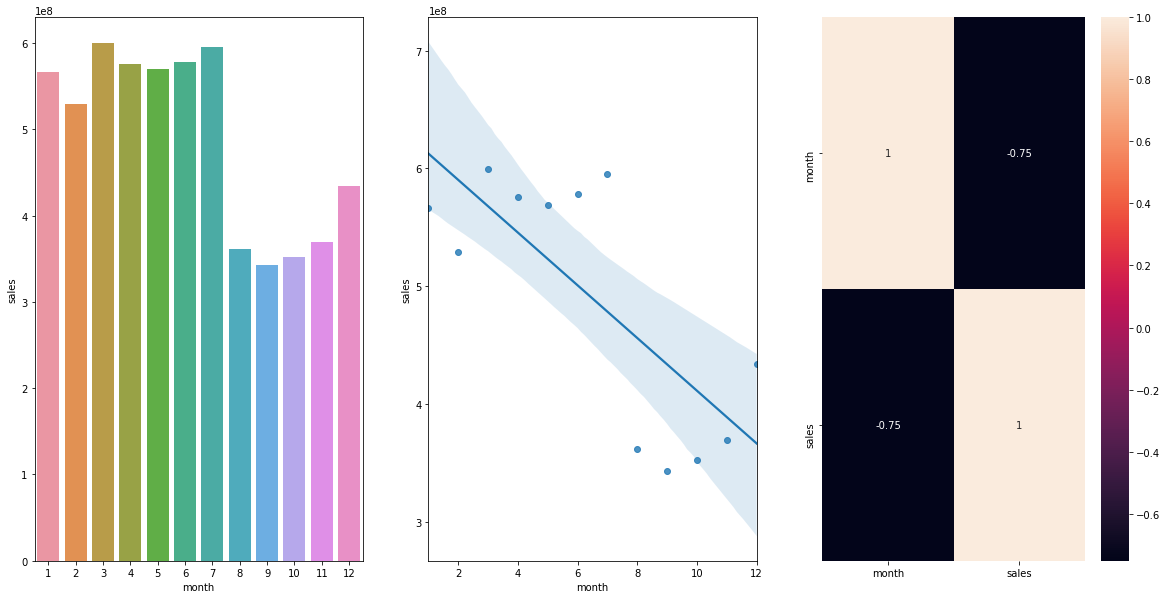

In [35]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(data=aux1, x='month', y='sales');

plt.subplot(1,3,2)
sns.regplot(data=aux1, x='month', y='sales');

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H9.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** - Lojas vendem mais depois do dia 10 de cada mês.

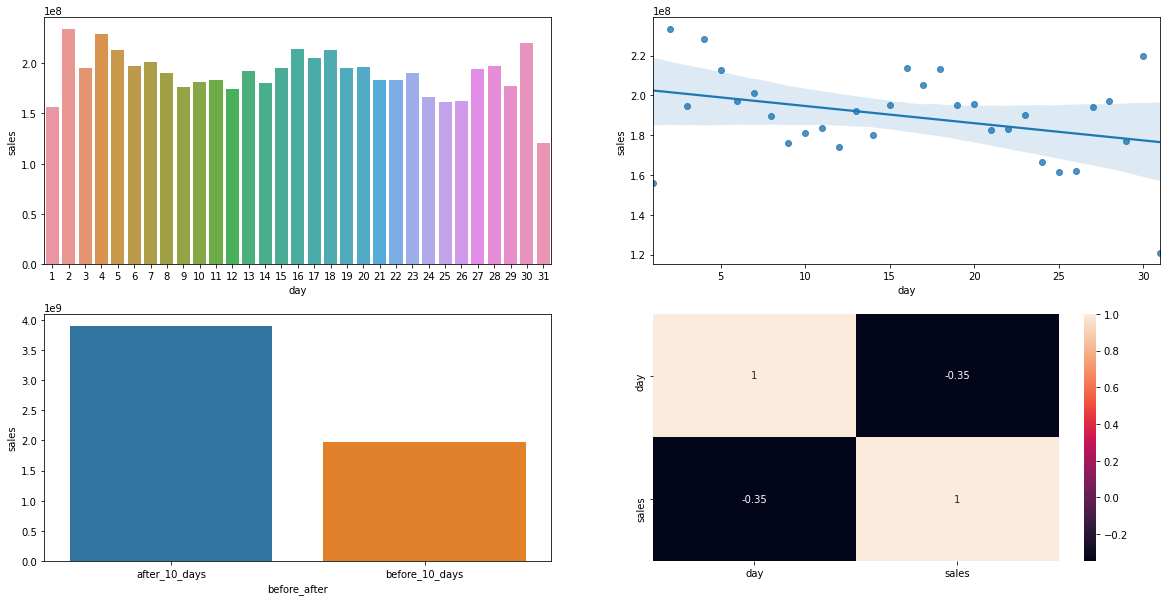

In [36]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()
plt.subplot(2,2,1)
sns.barplot(data=aux1, x='day', y='sales');

plt.subplot(2,2,2)
sns.regplot(data=aux1, x='day', y='sales');

plt.subplot(2,2,3)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <=10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(data=aux2, x='before_after', y='sales');

plt.subplot(2,2,4)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H10.** Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** - Lojas vendem menos no final de semana.

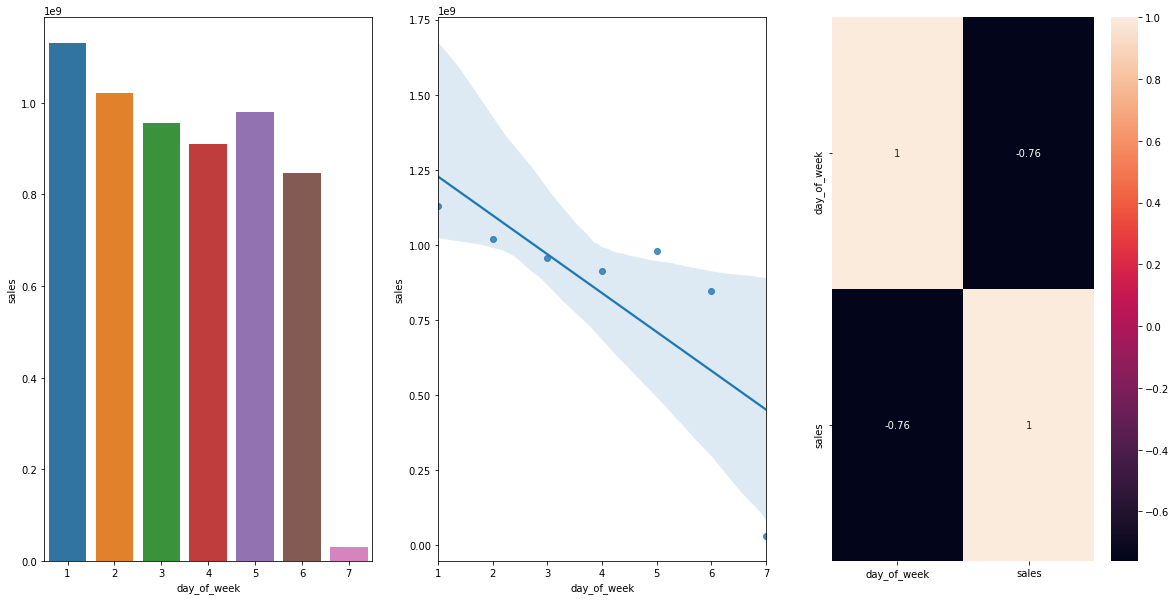

In [37]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(data=aux1, x='day_of_week', y='sales');

plt.subplot(1,3,2)
sns.regplot(data=aux1, x='day_of_week', y='sales');

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H11.** Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** - Lojas vendem menos durante os feriados escolares, exceto no mês de agosto.

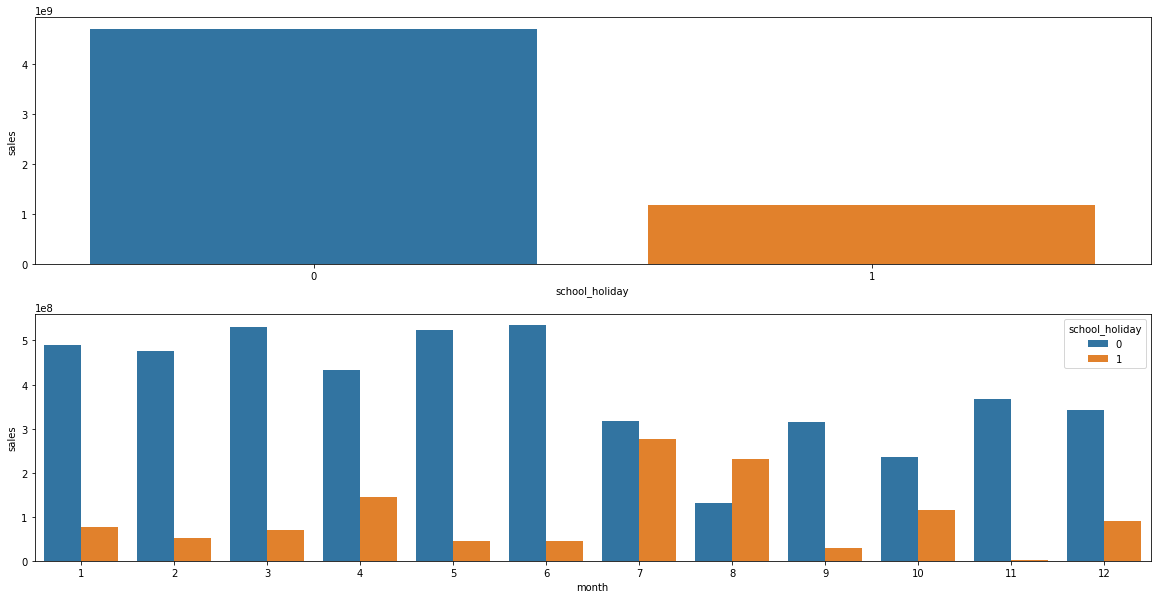

In [38]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2,1,1)
sns.barplot(data=aux1, x='school_holiday', y='sales');

plt.subplot(2,1,2)
aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(data=aux2, x='month', y='sales', hue='school_holiday');

## 4.5 Análise Multivariada

### 4.5.1 Variáveis Numéricas

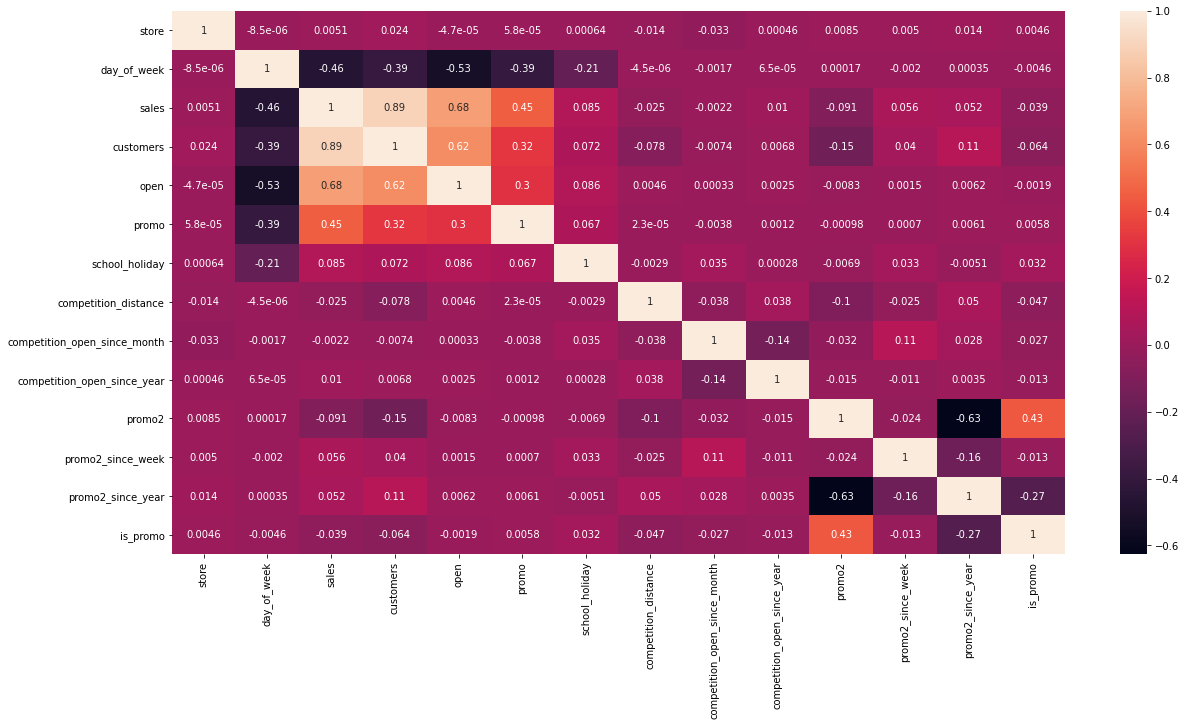

In [39]:
correlacao = num_attributes.corr(method='pearson')
sns.heatmap(correlacao, annot=True);

### 4.5.2 Variáveis Categóricas

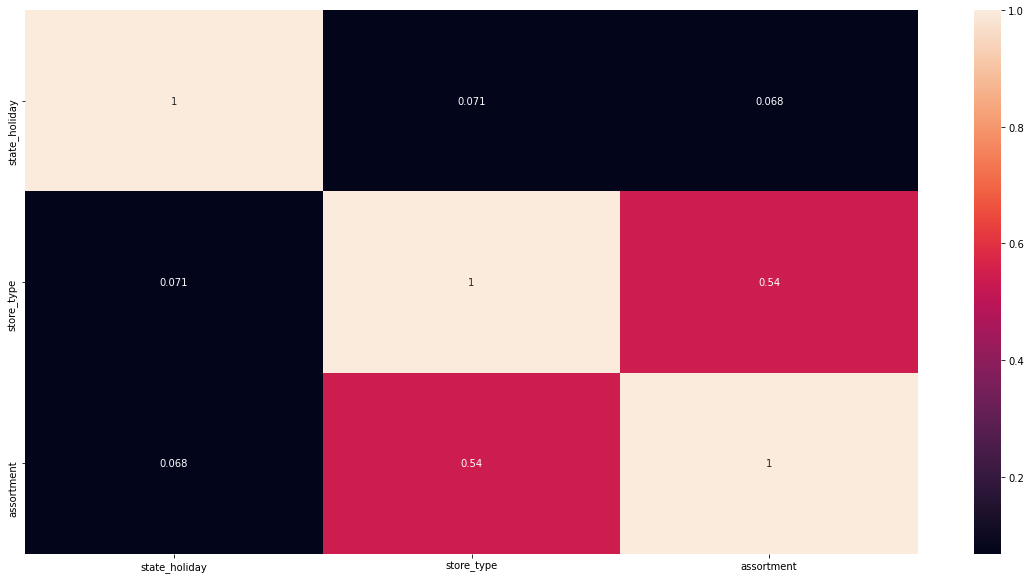

In [40]:
df_cat = df4.select_dtypes(include='object')

corr1 = cramer_v(df_cat['state_holiday'], df_cat['state_holiday'])
corr2 = cramer_v(df_cat['state_holiday'], df_cat['store_type'])
corr3 = cramer_v(df_cat['state_holiday'], df_cat['assortment'])

corr4 = cramer_v(df_cat['store_type'], df_cat['state_holiday'])
corr5 = cramer_v(df_cat['store_type'], df_cat['store_type'])
corr6 = cramer_v(df_cat['store_type'], df_cat['assortment'])

corr7 = cramer_v(df_cat['assortment'], df_cat['state_holiday'])
corr8 = cramer_v(df_cat['assortment'], df_cat['store_type'])
corr9 = cramer_v(df_cat['assortment'], df_cat['assortment'])

df_corr = pd.DataFrame({'state_holiday': [corr1,corr2,corr3],
                        'store_type':    [corr4,corr5,corr6],
                        'assortment':    [corr7,corr8,corr9]})
df_corr = df_corr.set_index(df_corr.columns)
sns.heatmap(df_corr, annot=True);

# 5.0 Preparação dos Dados

In [144]:
df5 = df4.copy()

## 5.1 Reescala

In [145]:
rs = RobustScaler()  ### Utilizado em atributos com outliers bem definidos
mms = MinMaxScaler() ### Utilizado em atributos sem outliers ou com outliers não muito significativos

In [146]:
# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)

## 5.2 Transformação

### 5.2.1 Encoding

In [147]:
# state_holiday
ohe = OneHotEncoder(cols=['state_holiday'], use_cat_names=True)
df5 = ohe.fit_transform(df5)

# store_type
oe = OrdinalEncoder(cols=['store_type'])
df5 = oe.fit_transform(df5)

# assortment
df5['assortment'] = df5['assortment'].map({'basic': 1, 'extra': 2, 'extended': 3})

D:\anaconda3\envs\previsao_rossmann\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
